# Redes convolucionales: primer ejemplo

Veremos el primer ejemplo exitoso de aplicación de redes convolucionales. Este ejemplo es una red relativamente chica, y trata de reconocimiento de dígitos representados por imágenes de 16x16. Esta demostración está derivada de los ejemplos de `lasagne` que se pueden encontrar al instalarla.

### Preparación de datos

Cargamos los datos a un dataframe de pandas. Los datos fueron extraídos del paquete ElemStatLearn de R.

In [125]:
import time
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rcParams


import pandas as pd
pd.options.display.max_rows = 10


df_train = pd.read_csv('zip_train.csv', sep=',')
df_test = pd.read_csv('zip_test.csv', sep=',')
print df_train.shape
print df_test.shape
df_train

(7291, 257)
(2007, 257)


,X1,X2,X3,X4,X5,X6,X7,X8,X9,X10,...,X248,X249,X250,X251,X252,X253,X254,X255,X256,X257
0,6,-1,-1,-1,-1.000,-1.000,-1.000,-1.000,-0.631,0.862,...,0.304,0.823,1.000,0.482,-0.474,-0.991,-1.000,-1.000,-1.000,-1
1,5,-1,-1,-1,-0.813,-0.671,-0.809,-0.887,-0.671,-0.853,...,-0.671,-0.671,-0.033,0.761,0.762,0.126,-0.095,-0.671,-0.828,-1
2,4,-1,-1,-1,-1.000,-1.000,-1.000,-1.000,-1.000,-1.000,...,-1.000,-1.000,-1.000,-0.109,1.000,-0.179,-1.000,-1.000,-1.000,-1
3,7,-1,-1,-1,-1.000,-1.000,-0.273,0.684,0.960,0.450,...,-0.318,1.000,0.536,-0.987,-1.000,-1.000,-1.000,-1.000,-1.000,-1
4,3,-1,-1,-1,-1.000,-1.000,-0.928,-0.204,0.751,0.466,...,0.466,0.639,1.000,1.000,0.791,0.439,-0.199,-0.883,-1.000,-1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7286,3,-1,-1,-1,-0.988,-0.527,-0.208,0.620,1.000,0.467,...,-0.116,0.899,0.416,-0.510,-1.000,-1.000,-1.000,-1.000,-1.000,-1
7287,3,-1,-1,-1,-0.990,0.708,0.557,0.347,-0.107,-0.758,...,0.697,0.636,0.167,-0.968,-1.000,-1.000,-1.000,-1.000,-1.000,-1
7288,3,-1,-1,-1,-0.783,-0.984,-0.827,0.068,1.000,1.000,...,0.805,1.000,1.000,0.727,-0.342,-0.933,-1.000,-1.000,-1.000,-1
7289,0,-1,-1,-1,-1.000,-1.000,-0.549,0.463,0.999,0.999,...,-0.231,0.621,0.999,-0.042,-0.231,-0.687,-1.000,-1.000,-1.000,-1


Extraemos las columnas con las intensidades de los pixeles y los convertimos en vectores de np, y extraemos también las etiquetas:

In [126]:
x_train_1 = np.float32(df_train.iloc[:,1:257].values)
x_test_1 = np.float32(df_test.iloc[:,1:257].values)
y_train = np.int32(df_train['X1'])
y_test = np.int32(df_test['X1'])

print x_train_1.shape
print x_train_1
print y_train


(7291, 256)
[[-1.         -1.         -1.         ..., -1.         -1.         -1.        ]
 [-1.         -1.         -1.         ..., -0.671      -0.82800001 -1.        ]
 [-1.         -1.         -1.         ..., -1.         -1.         -1.        ]
 ..., 
 [-1.         -1.         -1.         ..., -1.         -1.         -1.        ]
 [-1.         -1.         -1.         ..., -1.         -1.         -1.        ]
 [-1.         -1.         -1.         ..., -1.         -1.         -1.        ]]
[6 5 4 ..., 3 0 1]


Ahora graficamos los datos. Nótese que en este ejemplo rellenamos pixeles oscuros alrededor de la imagen. Esto lo hacemos para poder hacer la convolución 5x5 sobre todos los pixeles de la imagen (también puede rellenarse con tamaño 4, para hacer convoluciones que cubran todos los pixeles en todas las posibles posiciones:

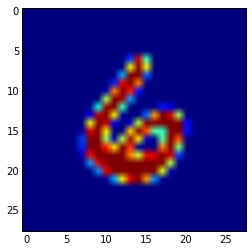

6


In [127]:
%matplotlib inline
plt.imshow(np.lib.pad(x_train_1[0,].reshape(16,16), (6,6), mode='constant', constant_values=-1))
plt.show()
print y_train[0]

Aquí hacemos el relleno (padding) de las imagenes, y las convertimos a matrices de 16x16. Nótese que ahora los conjuntos de entrenamiento y prueba son arreglos de 4 dimensiones (número de casos, 1, alto de imagen, ancho de imagen). Si fueran imágenes a color la segunda dimensión sería de tamaño 3 en lugar de 1

In [128]:
n_pad = 6
x_train = np.pad(x_train_1.reshape(x_train_1.shape[0], 1, 16, 16), 
                 ((0,0),(0,0),(n_pad,n_pad),(n_pad,n_pad)), mode='constant', constant_values=-1)
x_test = np.pad(x_test_1.reshape(x_test_1.shape[0], 1, 16, 16), 
                ((0,0),(0,0),(n_pad,n_pad),(n_pad,n_pad)), mode='constant', constant_values=-1)
#x_train = x_train_1.reshape(x_train_1.shape[0], 1, 16, 16)+1
#x_test = x_test_1.reshape(x_test_1.shape[0], 1, 16, 16)+1

print x_train[5][0].shape
print x_train.shape
print x_test.shape
#x_train[5][0]

(28, 28)
(7291, 1, 28, 28)
(2007, 1, 28, 28)


Necesitamos una función para iterar sobre los datos en mini-lotes. Esta función es un iterador:

In [129]:
def iterar_minilotes(entradas, respuesta, n_lote, mezclar):
    if mezclar:
        indices = np.arange(len(entradas))
        np.random.shuffle(indices)
    for i in range(0, len(entradas) - n_lote + 1, n_lote):
        if mezclar:
            parte = indices[i:i + n_lote]
        else:
            parte = slice(i, i + n_lote)
        yield entradas[parte], respuesta[parte]

In [130]:
it = iterar_minilotes(x_train, y_train, 6, mezclar = True)
a,b = it.next()
print b
a,b = it.next()
print b
a,b = it.next()
print b

for a,b in it:
    pass


[9 0 0 9 8 7]
[5 7 0 1 3 2]
[0 4 0 1 7 9]


 ### Arquitectura de red
 
 El código que sigue está derivado de los [ejemplos de lasagne](https://github.com/Lasagne/Lasagne/blob/master/examples/mnist.py). Empezamos cargando las librerías que necesitamos. Nótese el mensaje de que el GPU fue reconocido:

In [131]:
import lasagne
from lasagne import layers
from lasagne.nonlinearities import  softmax, rectify, sigmoid
import theano
import theano.tensor as T
from lasagne.regularization import regularize_layer_params_weighted, l2

Definimos variables para el tamaño de los datos de entrada y para el tamaño de lote:

In [132]:
im_ancho = 16 + 2*n_pad
im_alto = 16 + 2*n_pad

In [133]:
n_lote=400

Definimos ahora la arquitectura de la red, que en este primer ejemplo tiene:

1. una capa de convolución con 8 filtros, 
2. una capa de max pooling, luego 
3. una capa de convolución con 30 filtros, 
4. una capa de max pooling, 
5. una capa oculta totalmente conectada con 100 unidades, y finalmente 
6. la capa de salida que es totalmente conectada:

In [134]:
# Esto da la forma de entradas: los datos de entrada son de dmensión 
# num_casos x 1 x im_alto x im_anch0
# para imagenes en color es num_casos x 3 x im_alto x im_ancho (3=rgb)
entrada_var = T.tensor4('entradas')
respuesta_var = T.ivector('respuesta')

# Poner semilla, pues abajo se inicializan al azar los pesos

np.random.seed(8725)

# Ahora definimos las capas

capa_entrada = layers.InputLayer((n_lote, 1, im_ancho, im_alto), entrada_var)

capa_conv_1 = layers.Conv2DLayer(
    capa_entrada,
    num_filters = 4,
    filter_size = (5,5),
    nonlinearity = rectify)

capa_pool_1 = layers.MaxPool2DLayer(
    capa_conv_1,
    pool_size = (2,2)
)

capa_conv_2 = layers.Conv2DLayer(
    capa_pool_1,
    num_filters = 10,
    filter_size = (5,5),
    nonlinearity = rectify
)

capa_pool_2 = layers.MaxPool2DLayer(
    capa_conv_2,
    pool_size = (2,2)
)

#capa_oculta = layers.DenseLayer(
#    capa_pool_2,
#    num_units = 8,
#    nonlinearity = rectify
#)

capa_salida = layers.DenseLayer(
    capa_pool_2,
    num_units = 10,
    nonlinearity = softmax
)

En total, nuestra red tiene el siguiente número de parámetros:

In [135]:

print layers.count_params(capa_salida)
print capa_conv_1.W.get_value().shape
print capa_conv_2.W.get_value().shape
#print capa_oculta.W.get_value().shape
print capa_salida.W.get_value().shape

2724
(4, 1, 5, 5)
(10, 4, 5, 5)
(160, 10)


¿Cómo se ve, por ejemplo, la incialización de la primera capa?

(4, 1, 5, 5)
[[ 0.16448954  0.21868072  0.19367532 -0.19746259  0.09410992]
 [ 0.09979602 -0.19904077 -0.10835413  0.08268167  0.04086857]
 [-0.03652755 -0.0718561  -0.20396399  0.18297067 -0.1114347 ]
 [-0.08498354  0.18924432 -0.17541225  0.0739847   0.06894962]
 [ 0.07897285 -0.18638538 -0.15542826  0.12126783  0.21643192]]


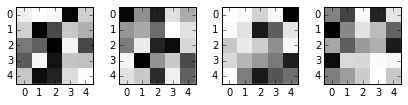

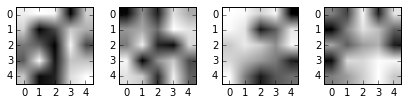

In [136]:
import matplotlib.cm as cm
import matplotlib.gridspec as gridspec

pesos_1 = capa_conv_1.W.get_value()
pesos_2 =  capa_conv_2.W.get_value()
print pesos_1.shape
print pesos_1[0,0,:,:]

fig  = plt.figure()
num_filt_1 = pesos_1.shape[0]
gs = gridspec.GridSpec(1, num_filt_1)
ax = [plt.subplot(gs[i]) for i in range(num_filt_1)]
gs.update(hspace=0)
gs.tight_layout(fig, h_pad=-2.0,w_pad=0.0)
for i in range(num_filt_1):
    ax[i].imshow(pesos_1[i,0,:,:], cmap = cm.Greys_r,  interpolation = 'none')
fig  = plt.figure()
num_filt_1 = pesos_1.shape[0]
gs = gridspec.GridSpec(1, num_filt_1)
ax = [plt.subplot(gs[i]) for i in range(num_filt_1)]
gs.update(hspace=0)
gs.tight_layout(fig, h_pad=-2.0,w_pad=0.0)
for i in range(num_filt_1):
    ax[i].imshow(pesos_1[i,0,:,:], cmap = cm.Greys_r)#, interpolation = 'none')
 

### Definición de pérdida y de optimización

Primero definimos la funciones necesarias para calcular la pérdida. Con salida obtenemos (cross entropy es devianza multinomial /2):

In [137]:
salida = lasagne.layers.get_output(capa_salida)
salida
perdida = lasagne.objectives.categorical_crossentropy(salida, respuesta_var)
perdida = perdida.mean() #calcular media sobre los datos que pasemos

Podemos definir la regularización simplemente sumando a la pérdida que establecimos arriba. La regularización es un parámetro que también podemos afinar:

In [138]:
reg_capas = {capa_conv_1:0.02, capa_conv_2:0.02, capa_salida:0.02}

l2_penalizacion = regularize_layer_params_weighted(reg_capas, l2)
perdida_reg = perdida + l2_penalizacion

Y ahora repetimos para calcular sobre la muestra de prueba, agregando también una función para el cálculo de la tasa de clasificación incorrecta:

In [139]:
salida_prueba = lasagne.layers.get_output(capa_salida, deterministic=True)
perdida_pr = lasagne.objectives.categorical_crossentropy(salida_prueba, respuesta_var)
perdida_pr = perdida_pr.mean()
error_pr = T.mean(T.eq(T.argmax(salida_prueba, axis=1), respuesta_var))

### Entrenamiento
En esta parte definimos los parámetros sobre los que queremos optimizar, y usamos actualización de 
descenso estocástico. En esta parte podemos ajustar la `learning_rate` para afinar la convergencia. En lo que sigue:

- Entrenaremos por **descenso estocástico con mini-lotes**.
- Escoger el **tamaño de minilote** suficientemente chico para no exceder la memoria del GPU, y aumentar para tener convergencia más rápida. Con minilotes demasiado chicos puede tardar más un recorrido sobre todos los datos (pasar datos de cpu a gpu).
- Una **época** es una vuelta completa a todos los datos.
- La **tasa de aprendizaje** tiene que ser suficientemente chica para evitar divergencia. Si el algoritmo parece converger en promedio pero  oscila mucho hacia el final, podemos bajar un poco la tasa de aprendizaje y obtener una solución ligeramente mejor. Se puede reducir hacia el final del entrenamiento también.

In [140]:
params = lasagne.layers.get_all_params(capa_salida, trainable = True)
updates = lasagne.updates.sgd(perdida_reg, params, learning_rate=0.025)
#updates = lasagne.updates.nesterov_momentum(
#        perdida_reg, params, learning_rate=0.01, momentum=0.9)

In [141]:
entrena_fn = theano.function([entrada_var, respuesta_var], perdida, updates = updates)
valid_fn = theano.function([entrada_var, respuesta_var], [perdida_pr, error_pr])


Y finalmente definimos la siguiente función para hacer le entrenamiento

In [142]:
def ajustar_red(num_epochs, x_train,y_train, x_test,y_test, entrena_fn, valid_fn):
    for epoch in range(num_epochs):
        train_err = 0
        train_batches = 0
        start_time = time.time()
        for batch in iterar_minilotes(x_train, y_train, n_lote, mezclar = True):
            inputs, targets = batch
            train_err += entrena_fn(inputs, targets)
            train_batches += 1
        # And a full pass over the validation data:
        val_err = 0
        val_acc = 0
        val_batches = 0
        for batch in iterar_minilotes(x_test, y_test, n_lote, mezclar=False):
            inputs, targets = batch
            err, acc = valid_fn(inputs, targets)
            val_err += err
            val_acc += acc
            val_batches += 1

        # Then we print the results for this epoch:
        if(epoch % 10 == 0 or epoch < 10):
            print("Época {} de {} tomó {:.3f}s".format(
                epoch + 1, num_epochs, time.time() - start_time))
            print("  pérdida entrenamiento:\t\t{:.4f}".format(train_err / train_batches))
            print("  pérdida validación:   \t\t{:.4f}".format(val_err / val_batches))
            print("  correctos validación: \t\t{:.2f} %".format(
                val_acc / val_batches * 100))
            


In [143]:
ajustar_red(150, x_train,y_train, x_test,y_test, entrena_fn, valid_fn)

Época 1 de 150 tomó 1.432s
  pérdida entrenamiento:		2.1806
  pérdida validación:   		2.0599
  correctos validación: 		35.10 %
Época 2 de 150 tomó 1.046s
  pérdida entrenamiento:		1.9304
  pérdida validación:   		1.7892
  correctos validación: 		40.80 %
Época 3 de 150 tomó 1.041s
  pérdida entrenamiento:		1.6079
  pérdida validación:   		1.4597
  correctos validación: 		52.55 %
Época 4 de 150 tomó 1.042s
  pérdida entrenamiento:		1.2653
  pérdida validación:   		1.1585
  correctos validación: 		66.30 %
Época 5 de 150 tomó 1.046s
  pérdida entrenamiento:		0.9762
  pérdida validación:   		0.9225
  correctos validación: 		74.20 %
Época 6 de 150 tomó 1.044s
  pérdida entrenamiento:		0.7581
  pérdida validación:   		0.7529
  correctos validación: 		79.55 %
Época 7 de 150 tomó 1.041s
  pérdida entrenamiento:		0.6059
  pérdida validación:   		0.6391
  correctos validación: 		83.25 %
Época 8 de 150 tomó 1.042s
  pérdida entrenamiento:		0.5005
  pérdida validación:   		0.5615
  correctos valida

### Evaluación y predicciones

Podemos extraer predicciones con el siguiente código (escogiendo la predicción como la clase con probabilidad más alta):

In [144]:
pred_prueba = lasagne.layers.get_output(capa_salida, deterministic=True)
predict_fn = theano.function([entrada_var], T.argmax(pred_prueba, axis=1))
preds = predict_fn(x_test)
print preds

[9 6 3 ..., 4 0 1]


In [145]:
from sklearn.metrics import confusion_matrix
print confusion_matrix(y_test, preds)
print len(y_test)
np.mean(y_test==preds)

[[351   0   1   1   2   0   2   1   0   1]
 [  0 257   0   1   2   0   4   0   0   0]
 [  4   0 181   2   4   0   0   1   6   0]
 [  2   0   3 153   0   8   0   0   0   0]
 [  0   2   3   0 184   2   3   2   0   4]
 [  3   0   0   6   0 148   0   0   1   2]
 [  0   0   1   0   3   1 165   0   0   0]
 [  1   0   2   1   5   0   0 136   0   2]
 [  4   0   2   1   1   3   1   0 154   0]
 [  0   2   0   0   2   0   0   2   3 168]]
2007


0.94519182859990036

### Cómo funciona la red ajustada
Podemos entender algo del funcionamiento de la red checando los pesos ajustados. Para la primera capa de convolución:

(4, 1, 5, 5)
[[[[ 0.09642728  0.23452714  0.2837283   0.16003722  0.04948449]
   [-0.02060208  0.03354351  0.17326228  0.27391452  0.1598893 ]
   [-0.13475712 -0.12459498 -0.06103342  0.1650167   0.18116301]
   [-0.15810223 -0.15359819 -0.16771209  0.00612051  0.14449817]
   [-0.14498006 -0.17596141 -0.17098019 -0.0359941   0.06785436]]]


 [[[-0.13127372 -0.15500669 -0.17200282 -0.16236086 -0.13642721]
   [-0.11817954 -0.16961363 -0.179814   -0.16095626 -0.12250211]
   [-0.02311717 -0.08708259 -0.10230132 -0.07750539 -0.00046313]
   [ 0.17491326  0.13409398  0.16270828  0.16704693  0.13126899]
   [ 0.26633781  0.31882304  0.30700171  0.24686037  0.12190816]]]


 [[[ 0.1323064   0.30855718  0.17518114 -0.03719503 -0.12326548]
   [ 0.22515701  0.3772113   0.07050443 -0.13992439 -0.11728659]
   [ 0.34243643  0.31658342 -0.09084282 -0.2206139  -0.1603954 ]
   [ 0.37613133  0.18092996 -0.19197157 -0.24253042 -0.19257568]
   [ 0.30023089  0.05330747 -0.22089949 -0.25965828 -0.19446076]]]




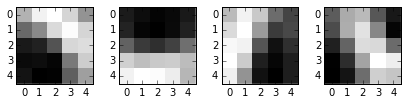

In [146]:
import matplotlib.cm as cm
import matplotlib.gridspec as gridspec
rcParams['figure.figsize'] = (6,10)


pesos_1 = capa_conv_1.W.get_value()
print pesos_1.shape
print pesos_1
print pesos_1[0,0,:,:]
print np.amax(pesos_1)
print np.amin(pesos_1)

fig  = plt.figure()
num_filt_1 = pesos_1.shape[0]
gs = gridspec.GridSpec(1, num_filt_1)
ax = [plt.subplot(gs[i]) for i in range(num_filt_1)]
gs.update(hspace=0)
gs.tight_layout(fig, h_pad=-2.0,w_pad=0.0)
for i in range(num_filt_1):
    ax[i].imshow(pesos_1[i,0,:,:], cmap = cm.Greys_r, interpolation = 'none')
    #ax[i].axis('off')

Como vemos, estos son filtros simples que intentan extraer bordes o gradientes en las imágenes. 

La siguientes capas son más difíciles de entender. En la segunda capa, tenemos 8 filtros para cada una de las ocho imagenes filtradas de la capa anterior:

In [147]:
pesos_2 = capa_conv_2.W.get_value()
print pesos_2.shape
pesos_2[:,0,:,:]
max_w = np.amax(pesos_2)
min_w = np.amin(pesos_2)
print min_w, max_w

(10, 4, 5, 5)
-0.133736 0.317212


Por ejemplo, extraemos los pesos del primer filtro para los datos filtrados de la primera capa anterior:

In [148]:
W_1 = pesos_2[0,0,:,:]
np.set_printoptions(suppress = True)
print W_1.shape
print W_1[:,:]

(5, 5)
[[ 0.03717044 -0.013153    0.02267613  0.03157703 -0.00579111]
 [ 0.00076911 -0.04455549  0.00261637  0.02757239 -0.02497837]
 [-0.01647919 -0.05436419  0.00249387  0.02090896 -0.05684981]
 [ 0.02117325 -0.04303981  0.00130811  0.04919351 -0.04921919]
 [ 0.00701153 -0.03789638 -0.01206587  0.04262687 -0.02424705]]


4 10


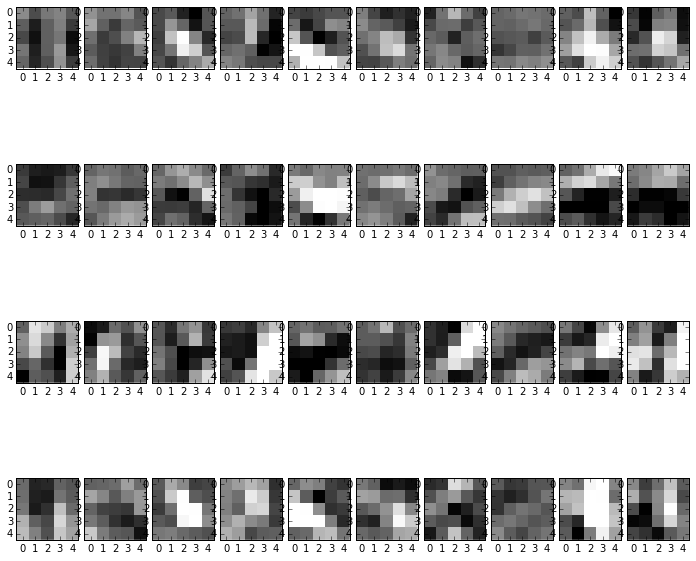

In [149]:
rcParams['figure.figsize'] = (10, 10)

fig  = plt.figure()
num_filt_2 = pesos_2.shape[0]
gs = gridspec.GridSpec(num_filt_1, num_filt_2, wspace=0.0,hspace=0.0)
print num_filt_1, num_filt_2
ax = [plt.subplot(gs[i]) for i in range(num_filt_1*num_filt_2)]
gs.update(hspace=5)
gs.tight_layout(fig, h_pad=-7.0,w_pad=-2.0)
for i in range(num_filt_1):
    for j in range(num_filt_2):
        ax[num_filt_2*i+j].imshow(pesos_2[j,i,:,:], cmap = cm.Greys_r, clim=(min_w/2,max_w/2),interpolation='none')
        #ax[num_filt_2*i+j].axis('off')

### Gráficas de activaciones

(2007, 4, 24, 24)
(4, 24, 24)
(2007, 10, 4, 4)
[6 3 2 6 0 0 0 6 9 6 2 2 4 0 3 1 6 9 6]


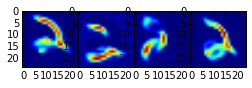

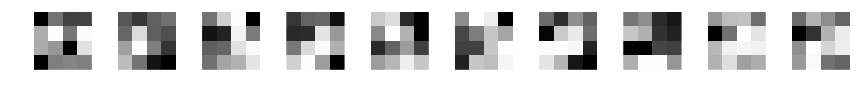

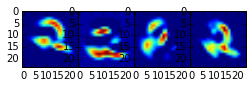

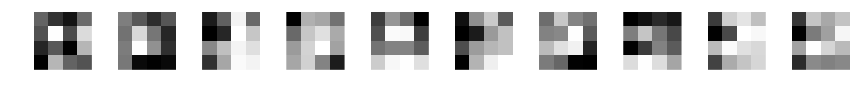

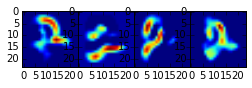

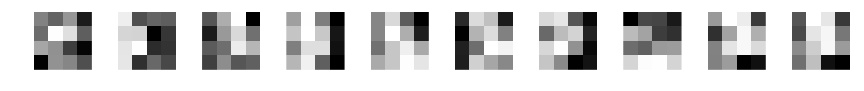

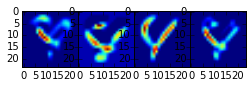

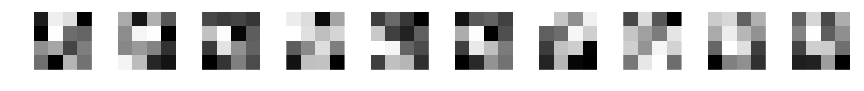

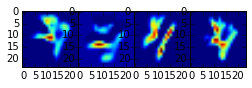

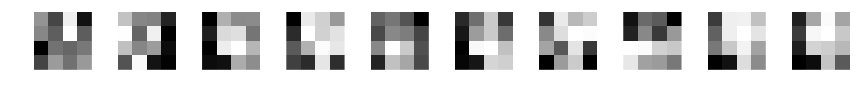

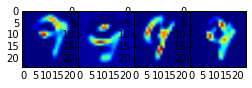

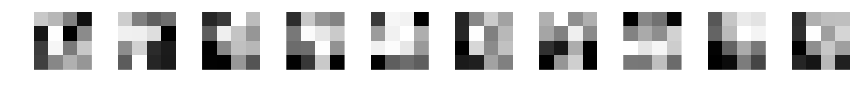

In [150]:

salida_c1 = lasagne.layers.get_output(capa_conv_1, deterministic=True)
predict_c1 = theano.function([entrada_var], salida_c1)
preds_c1 = predict_c1(x_test[:,:,:,:])
print preds_c1.shape

print preds_c1[11,:,:,:].shape

salida_c2 = lasagne.layers.get_output(capa_pool_2, deterministic=True)
predict_c2 = theano.function([entrada_var], salida_c2)
preds_c2 = predict_c2(x_test[:,:,:,:])
print preds_c2.shape
max_w = np.amax(preds_c2[:,:,:,:])
min_w = np.amin(preds_c2[:,:,:,:])

def plot_activ(n_fig):
    #rcParams['figure.figsize'] = (2, 3)
    #plt.imshow(x_test[n_fig,0,:,:], cmap = cm.Greys_r)
    rcParams['figure.figsize'] = (4,4)
    ## 1a capa
    fig  = plt.figure()
    gs = gridspec.GridSpec(1, 4, wspace=0.0,hspace=0.0)
    ax = [plt.subplot(gs[i]) for i in range(4)]
    for i in range(4):
        ax[i].imshow(preds_c1[n_fig,i,:,:])
    # 2a capa
    rcParams['figure.figsize'] = (12,6)
    fig  = plt.figure()
    gs = gridspec.GridSpec(1, 10, wspace=0.0,hspace=0.0)
    ax = [plt.subplot(gs[i]) for i in range(10)]
    gs.tight_layout(fig, h_pad=-0.0,w_pad=-0.0)

    for i in range(10):
        max_w = np.amax(preds_c2[n_fig,i,:,:])
        min_w = np.amin(preds_c2[n_fig,i,:,:])
        ax[i].imshow(preds_c2[n_fig,i,:,:], cmap = cm.Greys_r, interpolation='none',
                     clim=(min_w,max_w))
        ax[i].axis('off')

print preds[1:20]
plot_activ(11)
plot_activ(20)
plot_activ(58)
plot_activ(13)
plot_activ(62)
plot_activ(65)




### Regularización dropout

Para hacer dropout en el entrenamiento, en lasagne se ponen como capas de dropout. Esto tiene el efecto de escoger una proporción al azar de las entradas y poner sus coeficientes como cero (en el entrenamiento). Esto es una especie de regularización que intenta controlar coadaptación de neuronas (unas dependen de otras fuertemente para dar la salida correcta).



In [159]:
entrada_var = T.tensor4('entradas')
respuesta_var = T.ivector('respuesta')

capa_entrada = layers.InputLayer((n_lote, 1, im_ancho, im_alto), entrada_var)

#capa_dp_0 = layers.DropoutLayer(capa_entrada, p=0.5)

np.random.seed(2919235)

capa_conv_1 = layers.Conv2DLayer(
    capa_entrada,
    num_filters = 6,
    filter_size = (5,5),
    nonlinearity = rectify)

capa_pool_1 = layers.MaxPool2DLayer(
    capa_conv_1,
    pool_size = (2,2)
)

capa_dp_1 = layers.DropoutLayer(capa_pool_1, p=0.5)

capa_conv_2 = layers.Conv2DLayer(
    capa_pool_1,
    num_filters = 20,
    filter_size = (5,5),
    nonlinearity = rectify
)

capa_pool_2 = layers.MaxPool2DLayer(
    capa_conv_2,
    pool_size = (2,2)
)

capa_dp_2 = layers.DropoutLayer(capa_pool_2, p=0.5)

capa_oculta = layers.DenseLayer(
    capa_dp_2,
    num_units = 150,
    nonlinearity = rectify
)

capa_dropout = layers.DropoutLayer(capa_oculta, p=0.5)

capa_salida = layers.DenseLayer(
    capa_dropout,
    num_units = 10,
    nonlinearity = softmax
)


In [160]:
pred_2 = lasagne.layers.get_output(capa_salida)
perdida_2 = lasagne.objectives.categorical_crossentropy(pred_2, respuesta_var)
perdida_2 = perdida_2.mean()
reg_layers = {capa_oculta:0.001,capa_conv_1:0.001, capa_conv_2:0.001, 
              capa_salida:0.001}
l2_penalty = regularize_layer_params_weighted(reg_layers, l2)
perdida_reg_2 = perdida_2 + l2_penalty

# en la siguiente línea deterministic = True, para usar todas las neuronas 
# al predecir en muestra de prueba
prueba_pred = lasagne.layers.get_output(capa_salida, deterministic=True)
perdida_pr_2 = lasagne.objectives.categorical_crossentropy(prueba_pred, respuesta_var)
perdida_pr_2 = perdida_pr_2.mean()
test_acc = T.mean(T.eq(T.argmax(prueba_pred, axis=1), respuesta_var))

params_2 =lasagne.layers.get_all_params(capa_salida, trainable = True)
updates_2 = lasagne.updates.nesterov_momentum(perdida_reg_2, params_2, learning_rate=0.01,
                                              momentum=0.9)

entrena_fn_2 = theano.function([entrada_var, respuesta_var], perdida_2, updates=updates_2)
valid_fn_2 = theano.function([entrada_var, respuesta_var], [perdida_pr_2, test_acc])

ajustar_red(400, x_train,y_train, x_test,y_test, entrena_fn_2, valid_fn_2)


Época 1 de 400 tomó 1.939s
  pérdida entrenamiento:		2.2837
  pérdida validación:   		2.1151
  correctos validación: 		28.40 %
Época 2 de 400 tomó 1.509s
  pérdida entrenamiento:		2.0395
  pérdida validación:   		1.6946
  correctos validación: 		48.20 %
Época 3 de 400 tomó 1.512s
  pérdida entrenamiento:		1.6129
  pérdida validación:   		0.9989
  correctos validación: 		76.65 %
Época 4 de 400 tomó 1.511s
  pérdida entrenamiento:		1.1061
  pérdida validación:   		0.6118
  correctos validación: 		85.25 %
Época 5 de 400 tomó 1.509s
  pérdida entrenamiento:		0.7988
  pérdida validación:   		0.4379
  correctos validación: 		88.65 %
Época 6 de 400 tomó 1.510s
  pérdida entrenamiento:		0.6248
  pérdida validación:   		0.3614
  correctos validación: 		89.80 %
Época 7 de 400 tomó 1.509s
  pérdida entrenamiento:		0.5097
  pérdida validación:   		0.3063
  correctos validación: 		91.05 %
Época 8 de 400 tomó 1.509s
  pérdida entrenamiento:		0.4566
  pérdida validación:   		0.2827
  correctos valida

(6, 1, 5, 5)


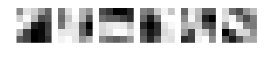

In [163]:

import matplotlib.cm as cm
import matplotlib.gridspec as gridspec
pesos_1 = capa_conv_1.W.get_value()
print pesos_1.shape

rcParams['figure.figsize'] = (4,4)
fig  = plt.figure()
num_filt_1 = pesos_1.shape[0]
gs = gridspec.GridSpec(1, num_filt_1)
ax = [plt.subplot(gs[i]) for i in range(num_filt_1)]
gs.update(hspace=0)
gs.tight_layout(fig, h_pad=-2.0,w_pad=-2.0)
for i in range(num_filt_1):
    ax[i].imshow(pesos_1[i,0,:,:], cmap = cm.Greys_r, interpolation = 'none')
    ax[i].axis('off')

In [164]:
pred_prueba = lasagne.layers.get_output(capa_salida, deterministic=True)
predict_fn = theano.function([entrada_var], T.argmax(pred_prueba, axis=1))
preds = predict_fn(x_test)
print confusion_matrix(y_test, preds)
print len(y_test)
np.mean(y_test==preds)

[[352   0   3   0   1   0   2   0   0   1]
 [  0 259   0   0   2   0   2   1   0   0]
 [  0   1 191   1   0   1   0   1   3   0]
 [  0   0   1 161   0   4   0   0   0   0]
 [  0   1   2   0 190   1   1   1   0   4]
 [  2   0   0   2   0 153   0   0   2   1]
 [  0   0   1   0   2   0 167   0   0   0]
 [  0   0   0   1   5   0   0 141   0   0]
 [  2   1   1   1   0   0   1   0 160   0]
 [  0   0   0   0   0   1   0   1   1 174]]
2007


0.97060288988540111

### Referencias

- [Redes convolucionales](https://www.youtube.com/watch?v=bEUX_56Lojc)
- [Documentación de Lasagne](http://lasagne.readthedocs.org)
- [Dropout](https://www.cs.toronto.edu/~hinton/absps/JMLRdropout.pdf)
- [Descenso con mini-lotes](https://class.coursera.org/neuralnets-2012-001/lecture/59)
- [Métodos de momento para mejorar descenso estocástico](https://class.coursera.org/neuralnets-2012-001/lecture/63)
- [Detección de objetos en imágenes]()
- [Visualización de redes convolucionales](https://www.cs.nyu.edu/~fergus/papers/zeilerECCV2014.pdf)
